In [5]:
from IPython.display import Image
from pydub import AudioSegment
from pyannote.audio import Pipeline
import whisper
import pandas as pd
from pyannote.audio import Audio
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import csv
import os
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
speaker_diarization = Pipeline.from_pretrained("pyannote/speaker-diarization@2.1", 
                                               use_auth_token=True)

model = whisper.load_model("medium") 

In [7]:
def convert_mp3_to_csv(mp3_file_path, speaker_diarization, model):
    # .mp3 to .wav
    file_name = os.path.basename(mp3_file_path)
    file_name_without_extension = os.path.splitext(mp3_file_path)[0]
    wav_file_path = file_name_without_extension + '.wav'
    audio = AudioSegment.from_mp3(mp3_file_path)
    audio.export(wav_file_path, format='wav')
#     first_minute = Segment(0, 20) # Eases testing if you need to debug/want to poke around with efficacy

    # Diarize
    who_speaks_when = speaker_diarization(file = wav_file_path, 
                                      num_speakers=None,  # these values can be
                                      min_speakers=None,  # provided by the user
                                      max_speakers=None)  # when they are known
    
    df = pd.DataFrame(columns=['speaker','text'])
    audio = Audio(sample_rate=16000, mono=True)
    # Transcribe via diarized segments
    for segment, _, speaker in who_speaks_when.itertracks(yield_label=True): #.crop(first_minute) for testing
        waveform, sample_rate = audio.crop(wav_file_path, segment)
        text = model.transcribe(waveform.squeeze().numpy())["text"]

        # Append the speaker and text to the DataFrame
        df.loc[len(df)] = [speaker, text]
    
    # Transcription to CSV
    df.to_csv(file_name_without_extension+'_transcribed.csv', index=False)
    print(f"successfully transcribed: {mp3_file_path}")
    
def convert_csv_to_sheets(csv_file_path, sheets_id, sheets_json):
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

    creds = ServiceAccountCredentials.from_json_keyfile_name(sheets_json, scope)

    client = gspread.authorize(creds)
    
    # Open the Google Sheets spreadsheet
    spreadsheet = client.open_by_key(sheets_id)

    # Create a new sheet with the title as the name of the CSV file
    worksheet = spreadsheet.add_worksheet(title=csv_file_path.replace('.csv', ''), rows="2000", cols="4")

    # Open the CSV file and read it into a list of lists
    with open(csv_file_path, 'r') as file_obj:
        reader = csv.reader(file_obj)
        rows = list(reader)

    # Update the sheet with the CSV data
    worksheet.insert_rows(rows, row=1)
    print(f"successfully sent to sheets: {csv_file_path}")

In [11]:
'''
The following will look for all mp3 files in present working directory, 
and attempt to transcribe>diarize>sheetsify each file. 

You may have to remove completed files in the event that a subsequent file fails, 
in order for this to not attempt that file again.
'''

# Get the current working directory
cwd = os.getcwd()

# Find all MP3 files in the current directory
mp3_files = [file for file in os.listdir(cwd) if file.endswith('.mp3')]

for mp3_file_path in mp3_files:
    # Create the corresponding CSV file name
    csv_file_path = mp3_file_path.replace('.mp3', '_transcribed.csv')
    
    # Check if the CSV file exists
    if not os.path.exists(csv_file_path):
        print(mp3_file_path)
        convert_mp3_to_csv(mp3_file_path, 
                           speaker_diarization, 
                           model)
        
        convert_csv_to_sheets(csv_file_path, 
                              'SHEET_KEY',
                              'get_appEngine_json_file.json')
        # SHEET_KEY comes from a google spreadsheet hash after the spreadsheets/d/SHEET_KEY_IS_HERE
        # https://docs.google.com/spreadsheets/d/THIS_IS_THE_SHEET_KEY/

sample.mp3
successfully transcribed: sample.mp3


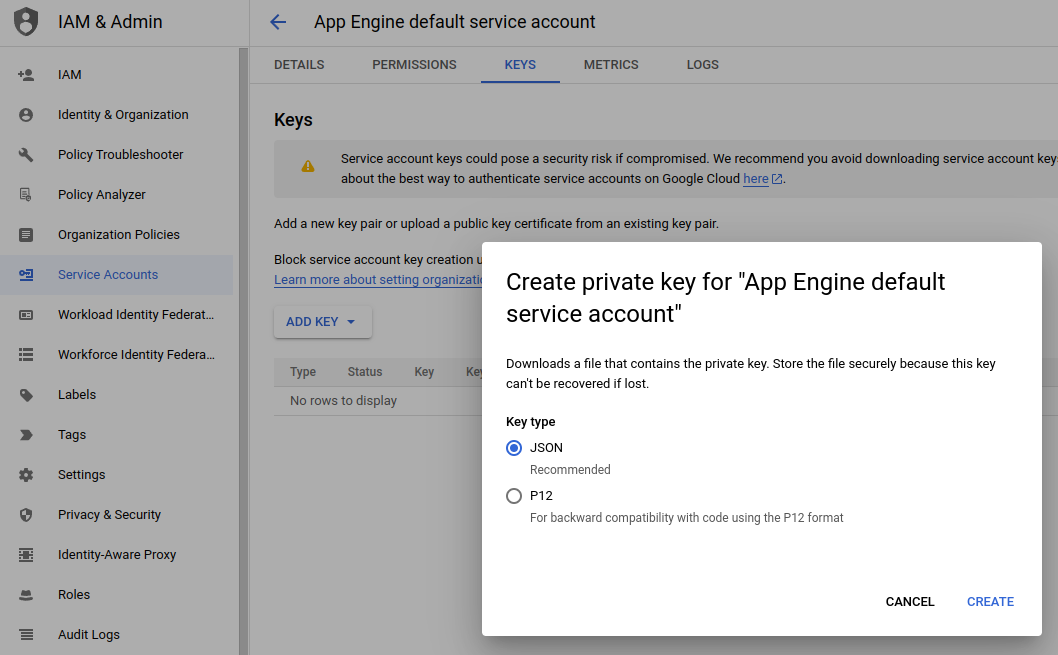

In [9]:
Image(filename="where_to_get_key.png")
# The .json file from above comes from:

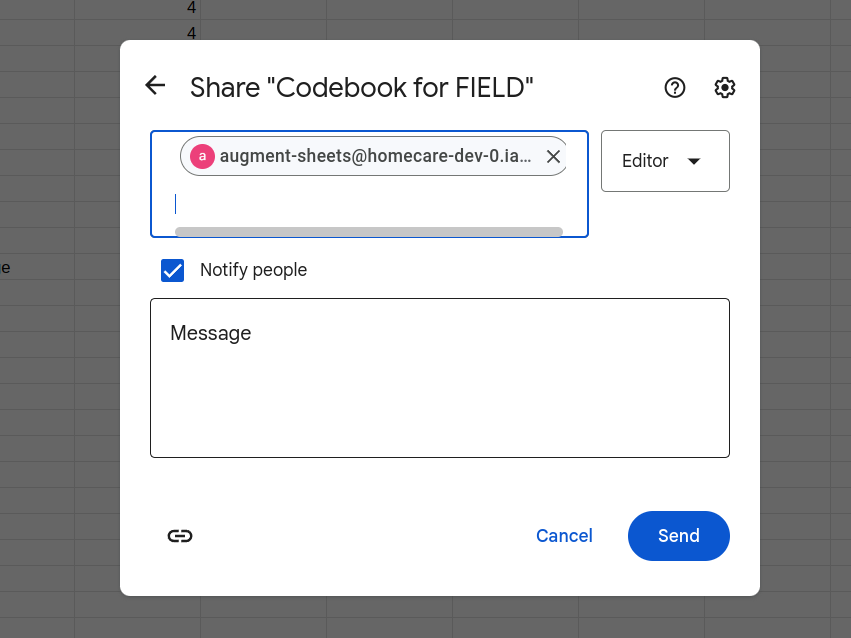

In [13]:
# You will also have to add the role email as an editor on the sheet, otherwise you'll get auth errors.
Image(filename="authorize.png")